In [2]:
# imports
import atc_dataloader, atc_model
import torch
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from atc_loss import PredictionLoss_COS_MSE, PredictionLoss_BOX_Wise

In [3]:
# set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [89]:
def transform_vector_to_integers(pred):
    # get the max value, that will serve as reference - where is the max, there is supposed to be 1 (or other integer, depends...)
    # for now, everything until 1.3 will be treated as 1, until 2.3 as two etc.
    
    # lambda to round function from the specific treshold defined in range [.0;1.0)
    my_treshold = 0.3
    tr = np.min([my_treshold, pred.max()*0.9])

    myround = np.vectorize(lambda x, treshold=tr: np.floor(x) if x < (np.floor(x) + treshold) else np.ceil(x))

    result = np.apply_along_axis(func1d=myround, axis=0,arr=pred)
    return result
    
    
def evaluate(model, data_loader, device, criterion):
    """
    function used to evaluate the model, return loss and accuracy
    """
    model.eval()
    
    y_true = []
    y_pred = []
    with torch.no_grad():
        total_ok = 0
        temp_loss = []
        for  _, batch_in_vectors, batch_out_vectors in data_loader:
            pred = model(batch_in_vectors.to(device))
            loss = criterion(pred, batch_out_vectors.to(device))
            temp_loss.append(loss.item())
            
            y_true.extend(batch_out_vectors)
            
            y_pred.extend(pred)
            
            print(len(y_true))
            print(len(y_pred))
            # print(y_true)
            # print(y_pred)
            break
        
        mean_loss = np.mean(temp_loss)
        
        print(total_ok, total_ok/len(data_train))
    return mean_loss

In [23]:
def train_model(model, device, dataloader, criterion, optimizer, epochs=10):
    model.train()  # Set the model to training mode
    
    loss_overall = []
    for epoch in range(epochs):
        epoch_loss = []
        # Wrap dataloader with tqdm for progress visualization
        
        for _, batch_in_vectors, batch_out_vectors in tqdm(dataloader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch'):
            # Convert data to tensors and move to the correct device
            batch_in_vectors = torch.tensor(batch_in_vectors, dtype=torch.float32).to(device)
            batch_out_vectors = torch.tensor(batch_out_vectors, dtype=torch.float32).to(device)
            
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_in_vectors)
            
            # Calculate loss
            loss = criterion(outputs, batch_out_vectors)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss
            epoch_loss.append(loss.item())

        # Print loss for the current epoch
        avg_loss = np.mean(epoch_loss)
        loss_overall.append(avg_loss) # add it to the loss over all epochs
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
    
    # plot graph
    plt.plot(np.arange(0,epochs,1),loss_overall)
    plt.title('Loss function')
    plt.show()



In [ ]:
# load data
TRAIN_IN="data/train_in.csv"
TRAIN_OUT="data/train_out.csv"

data_train = atc_dataloader.ATCDataset(TRAIN_IN, TRAIN_OUT)

TEST_IN="data/test_in.csv"
TEST_OUT="data/test_out.csv"

data_test = atc_dataloader.ATCDataset(TEST_IN, TEST_OUT)

In [24]:
model = atc_model.BaseNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, weight_decay=0.005)
dl_train = DataLoader(data_train, batch_size=32, shuffle=True)  
criterion = PredictionLoss_COS_MSE().to(device)

Epoch 1/10:   0%|          | 0/3768 [00:00<?, ?batch/s]/tmp/ipykernel_69246/2776324742.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_in_vectors = torch.tensor(batch_in_vectors, dtype=torch.float32).to(device)
/tmp/ipykernel_69246/2776324742.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_out_vectors = torch.tensor(batch_out_vectors, dtype=torch.float32).to(device)
Epoch 1/10: 100%|██████████| 3768/3768 [04:46<00:00, 13.14batch/s]


Epoch [1/10], Loss: 0.1818


Epoch 2/10: 100%|██████████| 3768/3768 [04:44<00:00, 13.23batch/s]


Epoch [2/10], Loss: 0.1689


Epoch 3/10: 100%|██████████| 3768/3768 [04:44<00:00, 13.23batch/s]


Epoch [3/10], Loss: 0.1597


Epoch 4/10: 100%|██████████| 3768/3768 [16:21<00:00,  3.84batch/s]    


Epoch [4/10], Loss: 0.1411


Epoch 5/10: 100%|██████████| 3768/3768 [04:48<00:00, 13.05batch/s]


Epoch [5/10], Loss: 0.0732


Epoch 6/10: 100%|██████████| 3768/3768 [04:44<00:00, 13.23batch/s]


Epoch [6/10], Loss: 0.0624


Epoch 7/10: 100%|██████████| 3768/3768 [04:41<00:00, 13.40batch/s]


Epoch [7/10], Loss: 0.0598


Epoch 8/10: 100%|██████████| 3768/3768 [04:43<00:00, 13.28batch/s]


Epoch [8/10], Loss: 0.0585


Epoch 9/10: 100%|██████████| 3768/3768 [8:23:13<00:00,  8.01s/batch]       


Epoch [9/10], Loss: 0.0574


Epoch 10/10: 100%|██████████| 3768/3768 [04:45<00:00, 13.18batch/s]

Epoch [10/10], Loss: 0.0568


In [ ]:
dl_test = DataLoader(data_test, batch_size=32, shuffle=False)
criterion = PredictionLoss_COS_MSE()
evaluate(model, dl_test, device, criterion)

# =========================

[0.1818 0.1689 0.1597 0.1411 0.0732 0.0624 0.0598 0.0585 0.0574 0.0568]


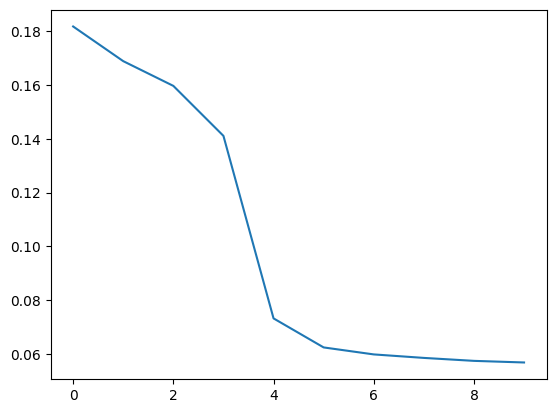

In [2]:
loss_vals = [0.1818,0.1689,0.1597,0.1411,0.0732,0.0624,0.0598,0.0585,0.0574,0.0568]
plt.plot(np.arange(0,10,1),loss_vals)
# regex to get number after word loss
import re 
text = """
Epoch 1/10: 100%|██████████| 3768/3768 [04:46<00:00, 13.14batch/s]
Epoch [1/10], Loss: 0.1818
Epoch 2/10: 100%|██████████| 3768/3768 [04:44<00:00, 13.23batch/s]
Epoch [2/10], Loss: 0.1689
Epoch 3/10: 100%|██████████| 3768/3768 [04:44<00:00, 13.23batch/s]
Epoch [3/10], Loss: 0.1597
Epoch 4/10: 100%|██████████| 3768/3768 [16:21<00:00,  3.84batch/s]    
Epoch [4/10], Loss: 0.1411
Epoch 5/10: 100%|██████████| 3768/3768 [04:48<00:00, 13.05batch/s]
Epoch [5/10], Loss: 0.0732
Epoch 6/10: 100%|██████████| 3768/3768 [04:44<00:00, 13.23batch/s]
Epoch [6/10], Loss: 0.0624
Epoch 7/10: 100%|██████████| 3768/3768 [04:41<00:00, 13.40batch/s]
Epoch [7/10], Loss: 0.0598
Epoch 8/10: 100%|██████████| 3768/3768 [04:43<00:00, 13.28batch/s]
Epoch [8/10], Loss: 0.0585
Epoch 9/10: 100%|██████████| 3768/3768 [8:23:13<00:00,  8.01s/batch]       
Epoch [9/10], Loss: 0.0574
Epoch 10/10: 100%|██████████| 3768/3768 [04:45<00:00, 13.18batch/s]
Epoch [10/10], Loss: 0.0568
"""
pattern = r'(?<=Loss:)\s*\d+\.\d*'
matches = re.findall(pattern, text)
matches = np.array(matches).astype(float)
print(matches)
plt.show()

In [ ]:
train_model(model, device, dl_train, criterion, optimizer, epochs=10)

In [25]:
# save model
torch.save(model.state_dict(), 'models/model_basenn2.pth')

# Working with already trained model

In [36]:
# load the weights to the model
model = atc_model.BaseNN().to(device)
model.load_state_dict(torch.load('models/model_basenn.pth'))

<All keys matched successfully>

In [8]:
idx = 2
target = data_train.__getitem__(idx)[2]
pred = model(data_train.__getitem__(idx)[1]) 
print(target)
print(pred)

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0.0807, 0.0806, 0.0767, 0.0896, 0.0916, 0.0810, 0.0730, 0.0753, 0.0657,
        0.0643, 0.0469, 0.0318, 0.0343, 0.0303, 0.0034, 0.0037, 0.0001, 0.0095],
       grad_fn=<ViewBackward0>)


In [34]:
# test the prediction loss
cos = nn.CosineSimilarity(dim=0, eps=1e-6)
mse = nn.MSELoss()
    
# Define weights for functions for Cos and MSE.
w1 = 5
w2 = 10
cc = cos(torch.tensor([.1,3,4]), torch.tensor([.1,3,4]))
# cc = cos(torch.cumsum(pred, dim=-1), torch.cumsum(target, dim=-1))
print(cc)
# Apply cumulative sum to both tensors and calculate loss.
cos_sim = torch.abs(cos(torch.cumsum(pred, dim=-1), torch.cumsum(target, dim=-1))).mean()
mse_loss = mse(torch.cumsum(pred, dim=-1), torch.cumsum(target, dim=-1))
loss = (w1 * mse_loss) / (w2 * cos_sim)
# penalty for the number of places, where prediction misses the zero in target
# let say where the 
non_zero_indices_target = np.count_nonzero(target)
max_value_pred = torch.max(pred)
# now everywhere the value goes up the half of max_value_pred penalty is count  --- this is self defined rule

print(non_zero_indices_target)

tensor(1.)
3


In [53]:
total_ok = 0
for d in data_train:
    if np.argmax(d[2]) == torch.argmax(model(d[1])):
        total_ok += 1
print(total_ok, total_ok/len(data_train))

14497 0.12025416206979503


In [4]:
res=np.sum([0.0807, 0.0806, 0.0767, 0.0896, 0.0916, 0.0810, 0.0730, 0.0753, 0.0657,
        0.0643, 0.0469, 0.0318, 0.0343, 0.0303, 0.0034, 0.0037, 0.0001, 0.0095])
res

0.9385